In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [40]:
import numpy
import scipy
import datetime as dtm
import matplotlib as mpl
import matplotlib.dates as mpd
import pylab as plt
#
import os
import sys
#
import netCDF4
#

In [3]:
fname_ave   = 'ary_1/atmos_average.nc'
fname_daily = 'ary_1/atmos_daily.nc'
#
fnames_daily = ['ary_4/atmos_daily_0.nc', 'ary_4/atmos_daily_1.nc']

In [8]:
with netCDF4.Dataset(fname_ave, 'r') as fout:
    print('** dims: {}\n'.format(fout.dimensions))
    print('** dims2: {}\n'.format([(d,dd) for d,dd in fout.dimensions.items()]))
    print('** ** dims3:')
    for d,dd in fout.dimensions.items():
        print('* * {}: {}, {}'.format(d,dd, len(dd)))
    #
    print('** vars: {}\n'.format([v for v in fout.variables]))
    #
    print('** time: {}\n'.format(fout.variables['time'][0]))

for fn in fnames_daily:
    with netCDF4.Dataset(fn, 'r') as f:
        print('** __dict__: ', f.__dict__)


** dims: OrderedDict([('phalf', <class 'netCDF4._netCDF4.Dimension'>: name = 'phalf', size = 41
), ('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 1
), ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 128
), ('lonb', <class 'netCDF4._netCDF4.Dimension'>: name = 'lonb', size = 129
), ('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 64
), ('latb', <class 'netCDF4._netCDF4.Dimension'>: name = 'latb', size = 65
), ('pfull', <class 'netCDF4._netCDF4.Dimension'>: name = 'pfull', size = 40
)])

** dims2: [('phalf', <class 'netCDF4._netCDF4.Dimension'>: name = 'phalf', size = 41
), ('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 1
), ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 128
), ('lonb', <class 'netCDF4._netCDF4.Dimension'>: name = 'lonb', size = 129
), ('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 64
), ('latb', <class 'netCDF4._netCDF4.Dimensi

In [37]:
#def concat_dycore_daily(fout_name='dycore_atmos_daily.nc', *args):
def concat_dycore_daily(fout_name='dycore_atmos_daily.nc', fnames=[]):
    '''
    # simple tool to concatenate dycore(-like) output NetCDF files.
    # for now, just assume the data files are created correctly (same dimensions and variables,
    #. not overlapping time, etc.)
    # So this is not fully general purpose, but it should be pretty robust.
    # TODO: Consider verifying this, aka that lat_1==lat_2, etc.
    #
    # NOTE: changed *args to fnames=[] model because it is too easy to accidentally just provide
    #. the inputs and overwrite the first input... which i don't know exactly what that would do...
    #. or actually even how that gets interpreted. This is more straight forward...
    '''
    #
    times    = []
    time_lens = []
    #
    #vars_of_interest=['ps', 'height', 'ucomp', 'vcomp', 'temp', 'omega', 'vor', 'time']
    #
    # create a counter index. This is a little redundant (we could just make vars_of_interest a dict{}),
    #. but 1) we have good control of the variables, 2) they don't have to persist, and 3) there is some
    #. safety and value to keeping them separate. though...
    # TODO: look through the code to see if we actually need vars_of_interest[]; originally there was
    #. a plan to do some sorting on this.
    #
    #vars_of_interest_index = {s:0 for s in vars_of_interest}
    #
    for fname in fnames:
        with netCDF4.Dataset(fname, 'r') as fout:
            time_lens += [fout.dimensions['time'].size]
            #times += [fout.variables['time'][0::fout.dimensions['time'].size-1]]
            times += [list(fout.variables['time'][[0,fout.dimensions['time'].size-1]])]
        #
    #
    time_lens = numpy.array(time_lens)
    times = numpy.array(times)
    #
    total_time_len = numpy.sum(time_lens)
    #
    # sorting index:
    ix = numpy.argsort(times[:,0])
    # 
    with netCDF4.Dataset(fout_name, 'w') as fout:
        # Start doing things:
        # copy __dict__, then overwrite as need be. presently, dycor only assigns filename 
        #. and title to __dict__. Let's emulate and overwrite as needed.
        #
        for k, (fname, ix) in enumerate(sorted(zip(fnames, ix), key=lambda rw:rw[1])):
            with netCDF4.Dataset(fname, 'r') as fin:
                # handle the k==0 case up front. Create dimensions and variables; assign non
                # f(t) variables:
                if k==0:
                    # create base elements. Assume all that are not f(t) are constant for all
                    #. inputs ? use last input???
                    # assign (presumed-to-be) static variables
                    #
                    time_dep_vars_index = {nm:0 for nm,v in fin.variables.items() 
                                              if 'time' in v.dimensions}
                    #
                    fout.setncatts(fin.__dict__)
                    #fout.__dict__['input_files']=['input_files']
                    fout.setncattr_string('input_files', fnames)
                    #fout.input_files = [['']]
                    #
                    for nm,dm in fin.dimensions.items():
                        if nm=='time':
                            n=total_time_len
                        else:
                            n = dm.size
                        #
                        fout.createDimension(nm, (n if not dm.isunlimited() else None) )
                        #fout.create_dimension(nm, n)
                    #
                    for nm, v in fin.variables.items():
                        #fout.create_variable()
                        x = fout.createVariable(nm, v.datatype, v.dimensions)
                        #
                        # if not time dependent, assign:
                        if not 'time' in v.dimensions:
                            # create variable, assign values, assign meta-data:
                            fout[nm][:] = fin[nm][:]
                            fout[nm].setncatts(fin[nm].__dict__)
                        #
                    #
                    #continue
                #
                # else k != 0
                #fout.__dict__['input_files'] += [fname]
                #fout.setncattr_string('input_files', fout.input_files + [fname])
                #print('*** DEBUG: ', type(fout.input_files), fout.input_files)
                #fout.input_files += [fname]
                # for all k, loop through vars_of_interest:
                for nm, k_v in time_dep_vars_index.items():
                    dk = fin.dimensions['time'].size
                    #
                    if len(fin[nm].dimensions)>1:
                        fout[nm][k_v:k_v + dk,:] = fin[nm][:]
                    else:
                        fout[nm][k_v:k_v + dk] = fin[nm][:]
                    #
                    fout[nm].setncatts(fin[nm].__dict__)
                    #
                    time_dep_vars_index[nm] += dk
                    #
                #
    #
    #return times, time_lens
    return None
#
#concat_dycore_daily('s1', 's2', 's3', 'end_string')
times, time_lens = concat_dycore_daily('ary_5/dycore_atmos_daily.nc',
                                            fnames=['ary_5/atmos_daily_0.nc', 'ary_4/atmos_daily_1.nc'])
#
print('** ', times)
print('** ', time_lens)

**  [[  1.  50.]
 [ 51. 100.]]
**  [50 50]


In [69]:
# How did we do?
#
#times, time_lens = concat_dycore_daily('ary_5/dycore_atmos_daily.nc',
#                                            fnames=['ary_5/atmos_daily_0.nc', 'ary_4/atmos_daily_1.nc'])
import pydycore as pdc
#
data_path = 'ary_5'
fout_name = 'dycore_atmos_daily.nc'
fin_names = ['atmos_daily_0.nc', 'atmos_daily_1.nc']
#
fins = [os.path.join(data_path, fn) for fn in fin_names]
fout_pathname = os.path.join(data_path, fout_name)
print('** fins: ', fins)
#
xx = pdc.concat_dycore_daily(fout_pathname, fins)
#
t_min = pdc.get_time('ary_4/atmos_daily_1.nc', which_time='min')
t_max = pdc.get_time('ary_4/atmos_daily_1.nc', which_time='max')
t1, t2 = pdc.get_time('ary_4/atmos_daily_1.nc', which_time='both')
#
print('*** ', t_min, t_max, t1, t2)


** fins:  ['ary_5/atmos_daily_0.nc', 'ary_5/atmos_daily_1.nc']
***  51.0 100.0 51.0 100.0


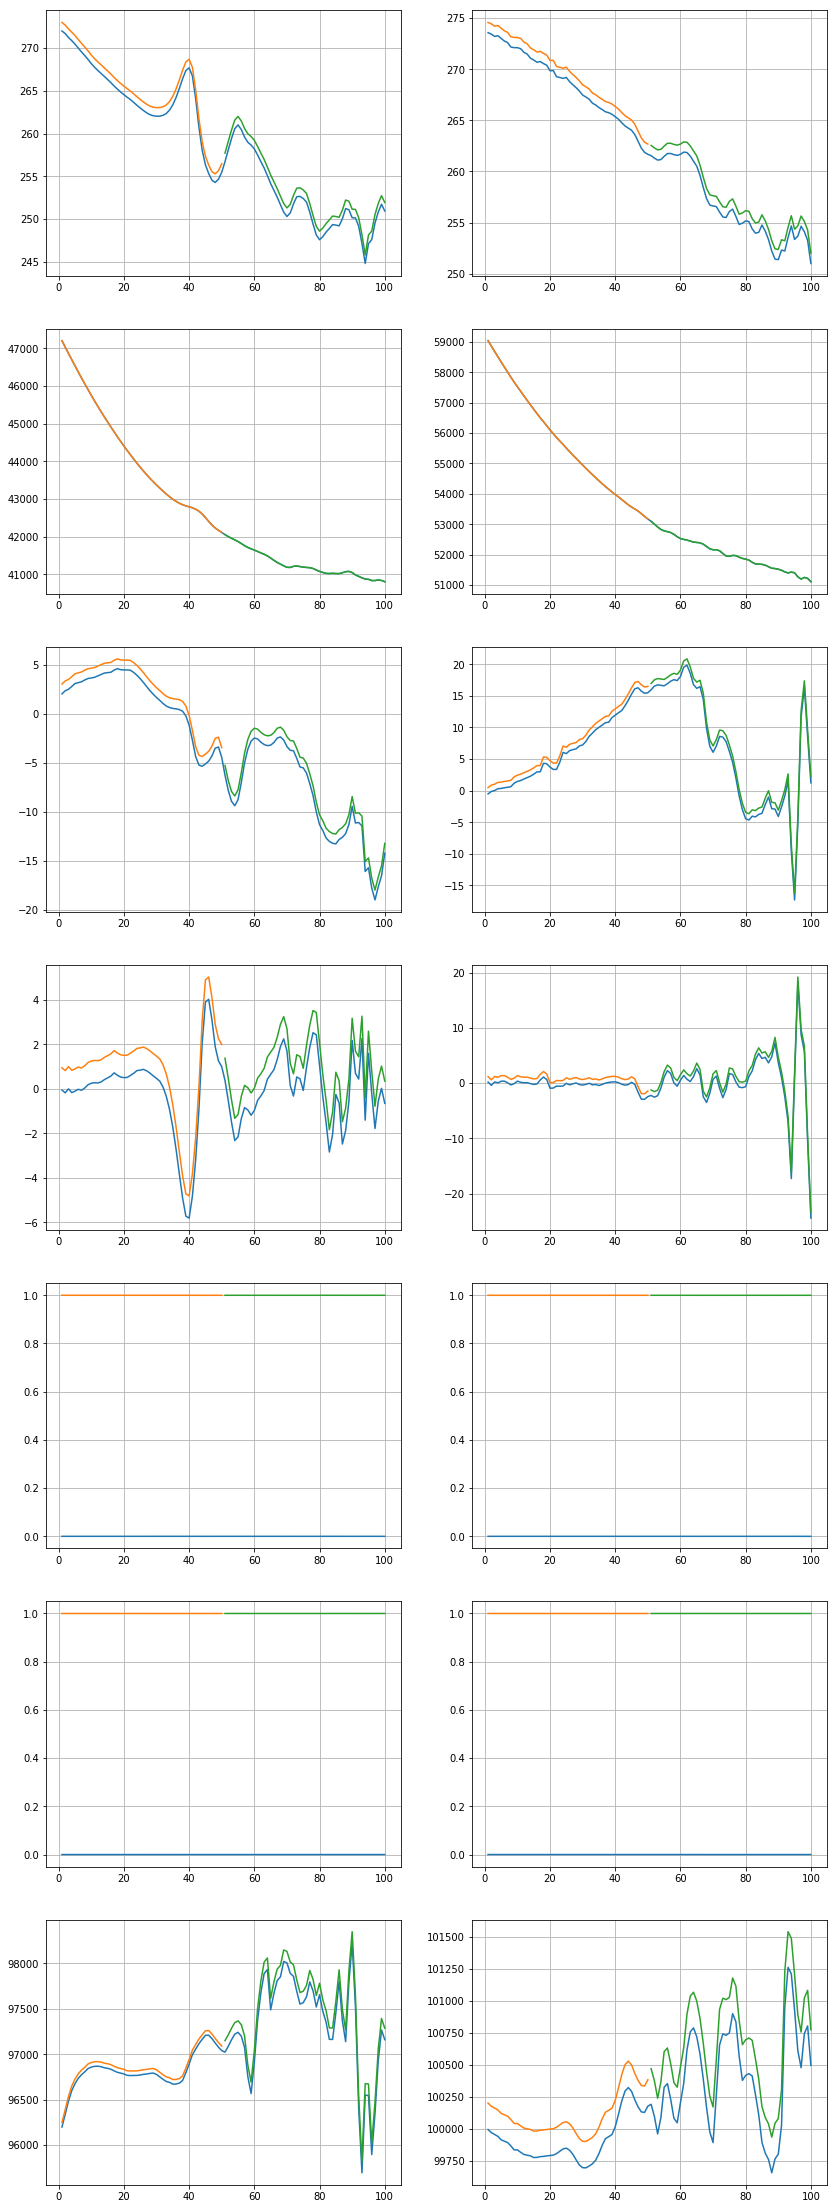

In [70]:
fg = plt.figure(figsize=(14,40))
axs = [fg.add_subplot(7,2,k+1) for k in range(14)]
for ax in axs:
    ax.grid()
#
with netCDF4.Dataset(fout_pathname, 'r') as f0, netCDF4.Dataset(fins[0], 'r') as f1, netCDF4.Dataset(fins[1], 'r') as f2:
    #
    for j, nm in enumerate(['temp', 'height', 'ucomp', 'vcomp', 'omega', 'vor']):
        for k,f in enumerate([f0, f1, f2]):
            axs[2*j + 0].plot(f['time'], f[nm][:,10,10,10] + (k>0), ls='-')
            axs[2*j + 1].plot(f['time'], f[nm][:,7,42,42] + (k>0), ls='-')
    #
    j=6
    for k,f in enumerate([f0, f1, f2]):
        #if k>0: break
        axs[2*j + 0].plot(f['time'], f['ps'][:,10,10] +
                          (k>0)*.05*(numpy.max(f['ps'][:,10,10])-numpy.min(f['ps'][:,10,10])), ls='-')
        axs[2*j + 1].plot(f['time'], f['ps'][:,42,42] +
                          (k>0)*.05*(numpy.max(f['ps'][:,42,42])-numpy.min(f['ps'][:,10,10])), ls='-')


In [17]:
with netCDF4.Dataset(fname_daily, 'r') as fout:
    print('** dims: {}\n'.format(fout.dimensions))
    print('** variables: {}\n'.format(fout.variables))
    print('** dims: {}\n'.format([d for d in fout.dimensions]))
    #
    print('** vars: {}\n'.format([v for v in fout.variables]))
    #
    #print('** variables: {}/n'.format(fout.variables))
    print('** variable shapes:')
    for vr in fout.variables:
        print('** ** {}: :{}, {}'.format(vr, fout.variables[vr].shape, fout.variables[vr].dimensions))
    #
    print('**\n')
    print('** time: {}\n'.format(fout.variables['time'][[0,-1]]))
    #
    print('** dims: ')
    for d in fout.dimensions:
        print('** d: {}:: {}'.format(fout.dimensions[d].name, fout.dimensions[d].size))
    

** dims: OrderedDict([('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 128
), ('lonb', <class 'netCDF4._netCDF4.Dimension'>: name = 'lonb', size = 129
), ('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 64
), ('latb', <class 'netCDF4._netCDF4.Dimension'>: name = 'latb', size = 65
), ('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 400
), ('pfull', <class 'netCDF4._netCDF4.Dimension'>: name = 'pfull', size = 40
), ('phalf', <class 'netCDF4._netCDF4.Dimension'>: name = 'phalf', size = 41
)])

** variables: OrderedDict([('lon', <class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    long_name: longitude
    units: degrees_E
    cartesian_axis: X
    edges: lonb
unlimited dimensions: 
current shape = (128,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('lonb', <class 'netCDF4._netCDF4.Variable'>
float32 lonb(lonb)
    long_name: longitude edges
    units: degrees_E
    cartesian_axis: X
unlimited dimens

In [16]:
with netCDF4.Dataset(fname_daily, 'r') as fout:
  
    for nm, vr in fout.variables.items():
        if not 'time' in vr.dimensions or nm=='time':
            print('** ** Statics:: {}: :{}, {}'.format(nm, vr.shape, vr.dimensions))
        if 'time' in vr.dimensions and len(vr.dimensions)>1:
            print('** ** f(time):: {}: :{}, {}, {}'.format(nm, vr.shape, vr.dimensions, len(vr.dimensions)))
        else:
            pass
            

** ** Statics:: lon: :(128,), ('lon',)
** ** Statics:: lonb: :(129,), ('lonb',)
** ** Statics:: lat: :(64,), ('lat',)
** ** Statics:: latb: :(65,), ('latb',)
** ** Statics:: time: :(400,), ('time',)
** ** Statics:: pfull: :(40,), ('pfull',)
** ** Statics:: phalf: :(41,), ('phalf',)
** ** f(time):: ps: :(400, 64, 128), ('time', 'lat', 'lon'), 3
** ** f(time):: height: :(400, 40, 64, 128), ('time', 'pfull', 'lat', 'lon'), 4
** ** f(time):: ucomp: :(400, 40, 64, 128), ('time', 'pfull', 'lat', 'lon'), 4
** ** f(time):: vcomp: :(400, 40, 64, 128), ('time', 'pfull', 'lat', 'lon'), 4
** ** f(time):: temp: :(400, 40, 64, 128), ('time', 'pfull', 'lat', 'lon'), 4
** ** f(time):: omega: :(400, 40, 64, 128), ('time', 'pfull', 'lat', 'lon'), 4
** ** Statics:: bk: :(41,), ('phalf',)
** ** f(time):: vor: :(400, 40, 64, 128), ('time', 'pfull', 'lat', 'lon'), 4


In [16]:
with netCDF4.Dataset(fname_daily, 'r') as fout:
    print('** ', fout.dimensions['time'].size)
    print('** ', fout.dimensions['time'].name)
    #
    print('** ', fout.variables['pfull'][:])
    print('** ', fout.variables['time'][:])
    #
    #print('** ', fout.variables['lon'][:])
    #print('** ', fout.variables['lonb'][:])

    #

**  400
**  time
**  [9.03715473e-03 1.77867692e-02 3.41535509e-02 6.40011504e-02
 1.17083140e-01 2.09169865e-01 3.65045965e-01 6.22568905e-01
 1.03793132e+00 1.69216776e+00 2.69877362e+00 4.21206522e+00
 6.43560314e+00 9.62967873e+00 1.41165495e+01 2.02818985e+01
 2.85709229e+01 3.94776764e+01 5.35266876e+01 7.12466583e+01
 9.31369858e+01 1.19628967e+02 1.51044540e+02 1.87556335e+02
 2.29153137e+02 2.75615234e+02 3.26502899e+02 3.81160889e+02
 4.38739624e+02 4.98232849e+02 5.58529114e+02 6.18473450e+02
 6.76935120e+02 7.32876038e+02 7.85416077e+02 8.33892639e+02
 8.77913940e+02 9.17410828e+02 9.52704590e+02 9.84665588e+02]
**  [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72